# Utilizar cross_val_score() para seleccionar parámetros para un modelo de aprendizaje automático.
* En esta práctica se utilizará la validación cruzada para seleccionar parámetros para un modelo de aprendizaje automático.
* Se define la función de utilidad **get_score()** que informe el MAE promedio (más de tres pliegues de validación cruzada) de pipeline de aprendizaje automático que utiliza:
  * los **datos en X e y** para crear pliegues,
  * **SimpleImputer()** (con todos los parámetros dejados por defecto) para reemplazar los valores faltantes,
  * **RandomForestRegressor()** (con random_state=0) para ajustarse a un modelo random forest.
* El parámetro **n_estimators** proporcionado a **get_score(**) se utiliza al configurar el número de árboles en el modelo Random Forest.

# Modelo de Machine Learning para estimar pecios de viviendas

* Se utliza los datos de la Competencia de precios de vivienda para usuarios de Kaggle Learn(https://www.kaggle.com/c/home-data-for-ml-course), donde utilizará 79 variables explicativas diferentes (como el tipo de techo, la cantidad de dormitorios y la cantidad de baños) para predecir los precios de las viviendas.

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split

# 1. Leer los datos
train_data = pd.read_csv('train.csv', index_col='Id')
test_data = pd.read_csv('test.csv', index_col='Id')

# 2. Eliminar filas con valores faltantes en la variable objetivo
train_data.dropna(axis=0, subset=['SalePrice'], inplace=True)

# 2.1 Separar variable objetivo de las predictoras
y = train_data.SalePrice
train_data.drop(['SalePrice'], axis=1, inplace=True)

In [2]:
# 2.2 Tamaño de los dataframe
print(f"El tamaño de train_data: {train_data.shape}")
print(f"El tamaño de test_data: {test_data.shape}")

El tamaño de train_data: (1460, 79)
El tamaño de test_data: (1459, 79)


In [3]:
# 3. "Cardinalidad" significa la cantidad de valores únicos en una columna
# Seleccione columnas categóricas con cardinalidad relativamente baja (conveniente pero arbitraria)
categorical_cols = [cname for cname in train_data.columns if
                    train_data[cname].nunique() < 10 and
                    train_data[cname].dtype == "object"]

# 4. Selecciona columnas numéricas
numerical_cols = [cname for cname in train_data.columns if
                train_data[cname].dtype in ['int64', 'float64']]

# 5. Mantenga solo las columnas seleccionadas
my_cols = categorical_cols + numerical_cols
X = train_data[my_cols].copy()
X_test =test_data[my_cols].copy()

In [4]:
# Tamaño de los dataframe despues de aplicar cardinalidad
print(f"El tamaño de X: {X.shape}")
print(f"El tamaño de X_test : {X_test.shape}")

El tamaño de X: (1460, 76)
El tamaño de X_test : (1459, 76)


### **Paso 1**: Definir función de utilidad get_score()

In [10]:
# Definción de función de utilidd get_score

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import cross_val_score

def get_score(n_estimators, X = X, y =y):
    # 1. Preprocesamiento de datos numéricos
    numerical_transformer = SimpleImputer(strategy='median')
    
    # 2. Preprocesamiento de datos categóricos
    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ]) 

    # 3. Preprocesamiento de paquetes para datos numéricos y categóricos
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numerical_transformer, numerical_cols),
            ('cat', categorical_transformer, categorical_cols)
        ])

    # 4. Crear pipeline con SimpleImputer y RandomForestRegressor
    my_pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor), # Imputación de valores faltantes con parámetros por defecto
        ('model', RandomForestRegressor(n_estimators=n_estimators, random_state=0)) # Modelo de Random Forest
    ])
    # Evaluar el modelo utilizando validación cruzada con MAE negativo
    scores = cross_val_score(my_pipeline, X, y, cv=3, scoring='neg_mean_absolute_error')

    # Calcular el MAE promedio (positivo)
    mae_average = -scores.mean()

    return mae_average

### Paso 2: Probar diferentes valores de parámetros
* Ahora, se utilizará la función que definió en el Paso 1 para evaluar el rendimiento del modelo correspondiente a ocho valores diferentes para la cantidad de árboles en el bosque aleatorio: 50, 100, 150, ..., 300, 350, 400.
* Los resultados se almacenan en un dicccionario de Python: **results**, donde **results**[i] es el MAE promedio devuelto por la función get_score(i).

In [11]:
# Valores de n_estimators a evaluar
n_estimators_values = [50, 100, 150, 200, 250, 300, 350, 400]

# Crear un diccionario para almacenar los resultados
results = {}

# Usar un bucle para evaluar cada valor de n_estimators
for n in n_estimators_values:
    score = get_score(n, X, y)
    results[n] = score
    print(f'n_estimators: {n}, MAE promedio: {score}')

n_estimators: 50, MAE promedio: 18057.953678832077
n_estimators: 100, MAE promedio: 18132.239140182468
n_estimators: 150, MAE promedio: 17991.024749757995
n_estimators: 200, MAE promedio: 17979.603878206482
n_estimators: 250, MAE promedio: 17952.22268798923
n_estimators: 300, MAE promedio: 17943.927657165874
n_estimators: 350, MAE promedio: 17949.456442966875
n_estimators: 400, MAE promedio: 17931.235367324793


### Paso 2.1 Visualización de los resultados

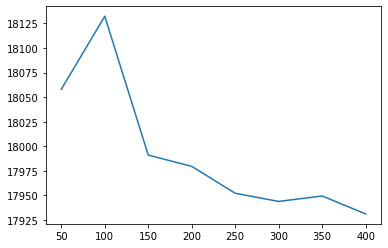

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline
# Se utiliza el resultado del diccionario result (x=keys, y=values)

plt.plot(list(results.keys()), list(results.values()))
plt.show()

### Paso 3: encuentre el mejor valor de parámetro
* Dados los resultados, el valor de n_estimators que mejor para el modelo de bosque aleatorio lo establecemos en **n_estimators_best**.

In [13]:
n_estimators_best = 400